In [1]:
# !python --version

Python 3.7.12


# Installing the Packages

In [2]:
import subprocess
whls = [
    "/kaggle/input/pyg-cp37-pt111/torch_cluster-1.6.0-cp37-cp37m-linux_x86_64.whl",
    "/kaggle/input/pyg-cp37-pt111/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl",
    "/kaggle/input/pyg-cp37-pt111/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl",
    "/kaggle/input/pyg-cp37-pt111/torch_spline_conv-1.2.1-cp37-cp37m-linux_x86_64.whl",
    "/kaggle/input/pyg-cp37-pt111/torch_geometric-2.2.0-py3-none-any.whl",
    "/kaggle/input/pyg-cp37-pt111/ruamel.yaml-0.17.21-py3-none-any.whl",
]
for w in whls:
    print("Installing", w)
    subprocess.call(["pip", "install", w, "--no-deps", "--upgrade"])

Installing /kaggle/input/pyg-cp37-pt111/torch_cluster-1.6.0-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/pyg-cp37-pt111/torch_cluster-1.6.0-cp37-cp37m-linux_x86_64.whl


Installing /kaggle/input/pyg-cp37-pt111/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/pyg-cp37-pt111/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl
Installing /kaggle/input/pyg-cp37-pt111/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl


Processing /kaggle/input/pyg-cp37-pt111/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl
Installing /kaggle/input/pyg-cp37-pt111/torch_spline_conv-1.2.1-cp37-cp37m-linux_x86_64.whl


Processing /kaggle/input/pyg-cp37-pt111/torch_spline_conv-1.2.1-cp37-cp37m-linux_x86_64.whl
Installing /kaggle/input/pyg-cp37-pt111/torch_geometric-2.2.0-py3-none-any.whl


Processing /kaggle/input/pyg-cp37-pt111/torch_geometric-2.2.0-py3-none-any.whl
Installing /kaggle/input/pyg-cp37-pt111/ruamel.yaml-0.17.21-py3-none-any.whl


Processing /kaggle/input/pyg-cp37-pt111/ruamel.yaml-0.17.21-py3-none-any.whl


# Importing the Modules

In [3]:
import torch
import torch.utils.data as data_utils
import torch_geometric
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import tqdm
from IPython import display
from types import MethodType
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import networkx as nx
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.cuda.amp import autocast
from tabulate import tabulate
from sklearn.decomposition import PCA
from PIL import Image
import os
import matplotlib.image as mpimg


# Image Transformations

In [6]:
transforms = torchvision.transforms
data_transform = {
    "train": transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                    transforms.Resize((224, 224)),
                                 transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]),
    "tes": transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])}        


# Loading The Dataset

In [7]:
train_dataset = torchvision.datasets.ImageFolder("/kaggle/input/brain-tumor-classification-mri/Training", transform=data_transform["train"])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = torchvision.datasets.ImageFolder("/kaggle/input/brain-tumor-classification-mri/Testing", transform=data_transform["tes"])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Data Visualization

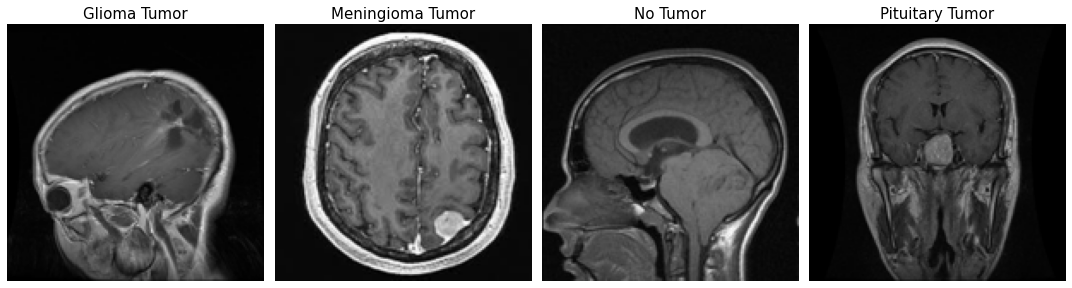

In [44]:


# Path to the Training folder
training_path = "/kaggle/input/brain-tumor-classification-mri/Training"

# List of folders within the Training folder
folders = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Mapping of folder names to their desired titles
title_map = {
    "glioma_tumor": "Glioma Tumor",
    "meningioma_tumor": "Meningioma Tumor",
    "no_tumor": "No Tumor",
    "pituitary_tumor": "Pituitary Tumor"
}

# Set the desired image size
image_size = (150, 150)

# Set up the figure for subplots
fig, axs = plt.subplots(1, len(folders), figsize=(15, 5))

# Display one resized image from each folder side by side
for i, folder in enumerate(folders):
    folder_path = os.path.join(training_path, folder)
    # Get the first image in each folder
    image_name = os.listdir(folder_path)[0]
    image_path = os.path.join(folder_path, image_name)

    # Open and resize the image
    img = Image.open(image_path)
    img = img.resize(image_size)

    # Display the resized image in the corresponding subplot
    axs[i].imshow(img)
    
    # Get the corresponding title from the title_map
    title = title_map.get(folder, folder)
    axs[i].set_title(title, fontsize=15)  # Adjust fontsize as needed
    axs[i].axis('off')

    # Print the image path
#     print(f"Image path for {title}: {image_path}")

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


Classes:  ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


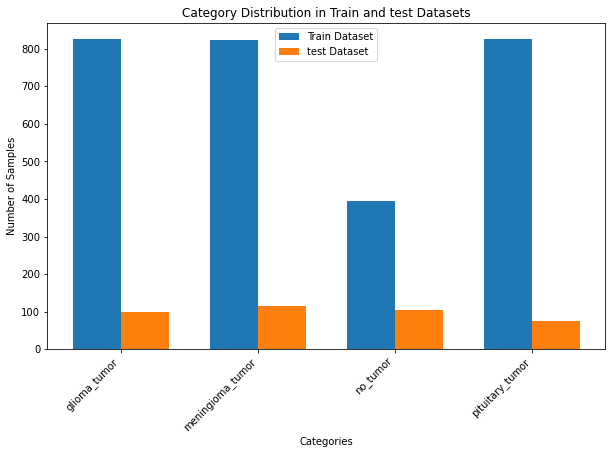

Number of Training Data points:  2870
Number of Testing Data points:  394


In [45]:
def plot_category_distribution(train_dataset, test_dataset):
    # Get the class names/categories from the dataset
    classes = train_dataset.classes
    print("Classes: ", classes)

    # Count occurrences of each category in the training dataset
    train_counts = [0] * len(classes)
    for _, label in train_dataset:
        train_counts[label] += 1

    # Count occurrences of each category in the test dataset
    test_counts = [0] * len(classes)
    for _, label in test_dataset:
        test_counts[label] += 1

    # Plot the bar graph
    width = 0.35  
    x = np.arange(len(classes))

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, train_counts, width, label='Train Dataset')
    rects2 = ax.bar(x + width/2, test_counts, width, label='test Dataset')

    # x-axis labels.
    ax.set_xlabel('Categories')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Category Distribution in Train and test Datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.legend()

    plt.show()



plot_category_distribution(train_dataset, test_dataset)
print("Number of Training Data points: ",len(train_dataset))
print("Number of Testing Data points: ",len(test_dataset))


# Training And Testing Functions

In [8]:
dtype = torch.float16
device = torch.device("cuda:0")
def train(model: nn.Module, num_epochs, train_loader, test_loader, lr):
    model.type(dtype)
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    lrc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=lr/10)
    loss_array = []
    acc_array = []
    
    for epoch in tqdm.tqdm(range(num_epochs)):
        running_loss, c = 0, 0
        
        for inputs, target in train_loader:
            inputs = inputs.type(dtype)
            inputs = inputs.to(device)
            target = target.to(device)

            y_pred = model(inputs)
            l = loss(y_pred, target)

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            running_loss += l
            c += 1
        
        loss_array.append(running_loss.item() / c)
        acc_array.append(test(model, test_loader))
        
    return loss_array, acc_array

In [9]:
@torch.no_grad()
def test(model,test_loader):
    correct=0
    total=0
    model.eval()
    model.to(device)
    model.type(dtype)
    
    with torch.no_grad():
        for data in test_loader:
            image,lables=data
            outputs=model(image.type(dtype).to(device))
            _,predicted=torch.max(outputs.data,dim=1)
            total+=lables.size(0)
            correct+=(predicted==lables.to(device)).sum().item()
    acc = correct/total
    return acc



# Defining the Models

In [11]:
def _forward_impl(self, x):
    x = x.type(dtype)  
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    return x

### VGG - 16 Model

In [12]:
class GraphCNN_VGG16(nn.Module):
    def __init__(self,k, num_classes):
        super().__init__()
        self.k = k
        self.num_classes = num_classes
        self.vgg16 = models.vgg16(pretrained=True)  # Load pre-trained VGG-16
        self.conv1 = torch_geometric.nn.GCNConv(512, 256)  # Adjust input dimension here
        self.dropout = nn.Dropout(0.5)
        self.conv2 = torch_geometric.nn.GCNConv(256, num_classes)
        
    def forward_features(self,X):
        features = self.vgg16.features(X)  # Extract features using VGG-16
#         print("VGG16 Features Shape:", features.shape)
#         print("Features: ", features)
        return features

    def convert_graph(self, x):
        b,c,h,w = x.shape
        device = x.device
        k = self.k
        x = torch.permute(x,(0,2,3,1)).reshape((b,h*w,c))
        y = torch.cdist(x,x,2)  # [b, hw, hw]
        _,idx = torch.topk(y,k,-1)
        source = torch.arange(h*w,device=device).repeat_interleave(k).repeat(b)
        target = torch.flatten(idx)
        step = torch.arange(b,device=device).repeat_interleave(h*w*k)*h*w
        adj = torch.row_stack([source,target]) + step
        return x.reshape((b*h*w,c)), adj.long()

    def froward_gcn(self,X,adj):
        X = self.conv1(X,adj)
        X = self.dropout(X)
        X = self.conv2(X,adj)  # (B*7*7, num_classes)
        return X

    def forward(self,X):
        batch = X.shape[0]
        X = self.forward_features(X)
        X,adj = self.convert_graph(X)
        X = self.froward_gcn(X,adj)
        X = torch.reshape(X,(batch, -1, self.num_classes))
        X = torch.mean(X,1) # (B, num_classes)
        return X


### DenseNet - 121 Model

In [13]:
class GraphCNN_Densenet121(nn.Module):
    def __init__(self,k, num_classes):
        super().__init__()
        self.k = k
        self.num_classes = num_classes
        self.densenet = models.densenet121(pretrained=True)  # Load pre-trained DenseNet-121
        self.conv1 = torch_geometric.nn.GCNConv(1024, 256)
        self.dropout = nn.Dropout(0.5)
        self.conv2 = torch_geometric.nn.GCNConv(256, num_classes)
        
    def forward_features(self,X):
        features = self.densenet.features(X)  # Extract features using DenseNet-121
#         print("DenseNet121 Features Shape:", features.shape)
#         print("Features: ", features)
        return features

    def convert_graph(self, x):
        b,c,h,w = x.shape
        device = x.device
        k = self.k
        x = torch.permute(x,(0,2,3,1)).reshape((b,h*w,c))
        y = torch.cdist(x,x,2)  # [b, hw, hw]
        _,idx = torch.topk(y,k,-1)
        source = torch.arange(h*w,device=device).repeat_interleave(k).repeat(b)
        target = torch.flatten(idx)
        step = torch.arange(b,device=device).repeat_interleave(h*w*k)*h*w
        adj = torch.row_stack([source,target]) + step
        return x.reshape((b*h*w,c)), adj.long()

    def froward_gcn(self,X,adj):
        X = self.conv1(X,adj)
        X = self.dropout(X)
        X = self.conv2(X,adj)  # (B*7*7, num_classes)
        return X

    def forward(self,X):
        batch = X.shape[0]
        X = self.forward_features(X)
        X,adj = self.convert_graph(X)
        X = self.froward_gcn(X,adj)
        X = torch.reshape(X,(batch, -1, self.num_classes))
        X = torch.mean(X,1) # (B, num_classes)
        return X


### ResNet-18 Model 

In [14]:
class GraphCNN_Resnet18(nn.Module):
    def __init__(self,k, num_classes):
        super().__init__()
        self.k = k
        self.num_classes = num_classes
        self.resnet = torchvision.models.resnet18(True)
        self.resnet._forward_impl = MethodType(_forward_impl,self.resnet)
        self.conv1 = torch_geometric.nn.GCNConv(512,256)
        self.dropout = nn.Dropout(0.5)
        self.conv2 = torch_geometric.nn.GCNConv(256,num_classes)
        
    def forward_features(self,X):
        # B * 512 * 7 * 7
        features = self.resnet(X)
#         print("ResNet-18 Features Shape:", features.shape)
#         print("Features: ", features)
        return features

    def convert_graph(self, x):
        b,c,h,w = x.shape
        device = x.device
        k = self.k
        x = torch.permute(x,(0,2,3,1)).reshape((b,h*w,c))
        y = torch.cdist(x,x,2)  # [b, hw, hw]
        _,idx = torch.topk(y,k,-1)
        source = torch.arange(h*w,device=device).repeat_interleave(k).repeat(b)
        target = torch.flatten(idx)
        step = torch.arange(b,device=device).repeat_interleave(h*w*k)*h*w
        adj = torch.row_stack([source,target]) + step
        return x.reshape((b*h*w,c)), adj.long()

    def froward_gcn(self,X,adj):
        X = self.conv1(X,adj)
        X = self.dropout(X)
        X = self.conv2(X,adj)  # (B*7*7, num_classes)
        return X

    def forward(self,X):
        batch = X.shape[0]
        X = self.forward_features(X)
        X,adj = self.convert_graph(X)
        X = self.froward_gcn(X,adj)
        X = torch.reshape(X,(batch, -1, self.num_classes))
        X = torch.mean(X,1) # (B, num_classes)
        return X


# Defining Functions for Visualization

### Function for the Training Loss - Test Accuracy Graph

In [15]:
def display_model_performance(loss_array, acc_array):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_array)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(acc_array)
    plt.title('test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()


### Function for displaying Accuracy

In [16]:
def display_loss_accuracy(loss_array, acc_array):
    for epoch, (loss, acc) in enumerate(zip(loss_array, acc_array), 1):
        print(f"Epoch {epoch} - Loss: {loss:.4f} - Accuracy: {acc:.4f}")

### Function for Building Receiver Operating Characteristic Curve

In [17]:
def plot_roc_curve(model_name, model, test_loader, num_classes):
    print(f"Model Name: {model_name}")
    model.eval()
    device = next(model.parameters()).device
    y_true = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert inputs to HalfTensor
            inputs = inputs.type(torch.cuda.HalfTensor)

            y_true.extend(labels.cpu().numpy())
            outputs = model(inputs)
            y_scores.extend(outputs.cpu().numpy())

    y_true = label_binarize(y_true, classes=np.arange(num_classes))
    y_scores = np.array(y_scores)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for {} Model'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()


### Function for Confusion Matrix Construction and Classification Report

In [18]:
@torch.no_grad()
def test_with_predictions(model, test_loader):
    model.eval()
    model.to(device)
    model.type(dtype)

    all_labels = []
    all_predictions = []

    for data in test_loader:
        images, labels = data
        images = images.type(dtype).to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)

        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.cpu().numpy())

    return all_labels, all_predictions

# Instantiating ResNet - 18 Model and Visualization

In [19]:
model_Resnet18 = GraphCNN_Resnet18(k=8,num_classes=4)


loss_array_Resnet18, acc_array_Resnet18 = train(model_Resnet18, 30, train_loader, test_loader, lr=0.001)

            
display_loss_accuracy(loss_array_Resnet18, acc_array_Resnet18)

100%|██████████| 30/30 [12:44<00:00, 25.48s/it]

Epoch 1 - Loss: 1.1410 - Accuracy: 0.5127
Epoch 2 - Loss: 1.0243 - Accuracy: 0.4188
Epoch 3 - Loss: 0.6399 - Accuracy: 0.3959
Epoch 4 - Loss: 0.5628 - Accuracy: 0.5685
Epoch 5 - Loss: 0.4997 - Accuracy: 0.5152
Epoch 6 - Loss: 0.4240 - Accuracy: 0.6091
Epoch 7 - Loss: 0.4128 - Accuracy: 0.6244
Epoch 8 - Loss: 0.3878 - Accuracy: 0.6447
Epoch 9 - Loss: 0.3757 - Accuracy: 0.6168
Epoch 10 - Loss: 0.3681 - Accuracy: 0.6371
Epoch 11 - Loss: 0.3333 - Accuracy: 0.6218
Epoch 12 - Loss: 0.3280 - Accuracy: 0.6726
Epoch 13 - Loss: 0.3142 - Accuracy: 0.5787
Epoch 14 - Loss: 0.3063 - Accuracy: 0.7081
Epoch 15 - Loss: 0.2941 - Accuracy: 0.6751
Epoch 16 - Loss: 0.2632 - Accuracy: 0.6523
Epoch 17 - Loss: 0.2689 - Accuracy: 0.7030
Epoch 18 - Loss: 0.2691 - Accuracy: 0.7081
Epoch 19 - Loss: 0.2724 - Accuracy: 0.6853
Epoch 20 - Loss: 0.2493 - Accuracy: 0.7335
Epoch 21 - Loss: 0.2576 - Accuracy: 0.7513
Epoch 22 - Loss: 0.2385 - Accuracy: 0.7107
Epoch 23 - Loss: 0.2352 - Accuracy: 0.7107
Epoch 24 - Loss: 0.2

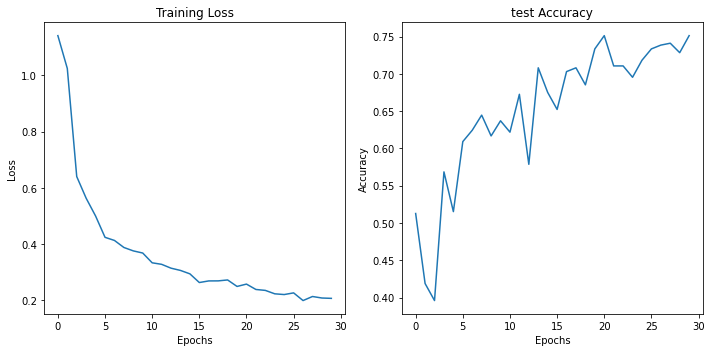

In [20]:
display_model_performance(loss_array_Resnet18, acc_array_Resnet18)

In [21]:
acc_Resnet18 = test(model_Resnet18, test_loader)

            
print("Test Accuracy: ", acc_Resnet18)

Test Accuracy:  0.7436548223350253


In [22]:
# Evaluate the model and get labels and predictions
true_labels, pred_labels = test_with_predictions(model_Resnet18, test_loader)

# Compute confusion matrix
conf_matrix_Resnet18 = confusion_matrix(true_labels, pred_labels)

# Compute classification report
class_report_Resnet18 = classification_report(true_labels, pred_labels)


In [23]:
print("Confusion Matrix:")
print(conf_matrix_Resnet18)

Confusion Matrix:
[[ 35  38  27   0]
 [  3 107   5   0]
 [  1   1 103   0]
 [  2   9  14  49]]


In [24]:
print("\nClassification Report:")
print(class_report_Resnet18)


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.35      0.50       100
           1       0.69      0.93      0.79       115
           2       0.69      0.98      0.81       105
           3       1.00      0.66      0.80        74

    accuracy                           0.75       394
   macro avg       0.81      0.73      0.72       394
weighted avg       0.79      0.75      0.72       394



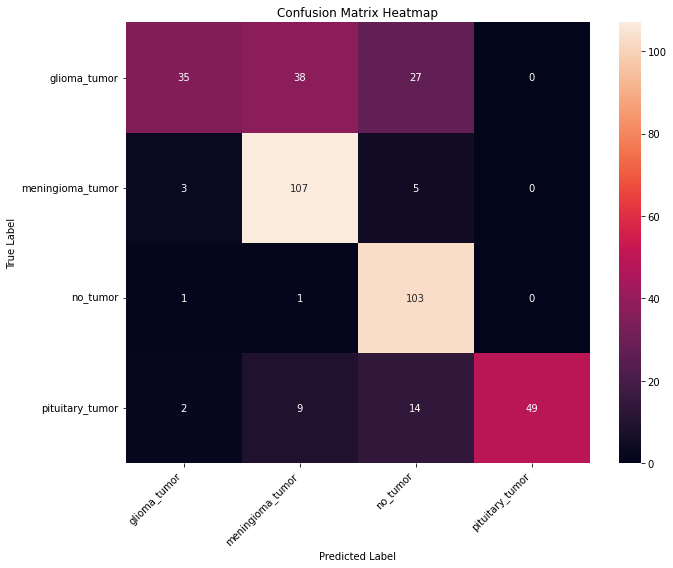

In [25]:
# Plot confusion matrix heatmap
plt.figure(figsize=(10,8))
plt.title("Confusion Matrix Heatmap - Resnet-18")
sns.heatmap(conf_matrix_Resnet18, annot=True, fmt="d", 
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Model Name: GNN-ResNet18


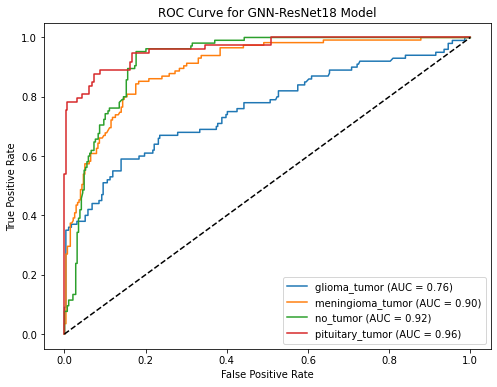

In [26]:
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
plot_roc_curve("GNN-ResNet18", model_Resnet18, test_loader, num_classes=4)

# Instantiating DenseNet - 121 Model and Visualization

In [27]:
model_Densenet121 = GraphCNN_Densenet121(k=8,num_classes=4)


loss_array_Densenet121, acc_array_Densenet121 = train(model_Densenet121, 100, train_loader, test_loader, lr=0.0001)

            
display_loss_accuracy(loss_array_Densenet121, acc_array_Densenet121)

100%|██████████| 100/100 [52:07<00:00, 31.27s/it]

Epoch 1 - Loss: 2.3306 - Accuracy: 0.3198
Epoch 2 - Loss: 1.2597 - Accuracy: 0.4289
Epoch 3 - Loss: 0.9347 - Accuracy: 0.4365
Epoch 4 - Loss: 0.7868 - Accuracy: 0.4645
Epoch 5 - Loss: 0.7340 - Accuracy: 0.4594
Epoch 6 - Loss: 0.7194 - Accuracy: 0.4365
Epoch 7 - Loss: 0.6837 - Accuracy: 0.5000
Epoch 8 - Loss: 0.6597 - Accuracy: 0.5203
Epoch 9 - Loss: 0.6253 - Accuracy: 0.5127
Epoch 10 - Loss: 0.6191 - Accuracy: 0.4898
Epoch 11 - Loss: 0.5851 - Accuracy: 0.5482
Epoch 12 - Loss: 0.5972 - Accuracy: 0.5355
Epoch 13 - Loss: 0.5712 - Accuracy: 0.5330
Epoch 14 - Loss: 0.5837 - Accuracy: 0.5279
Epoch 15 - Loss: 0.5545 - Accuracy: 0.5228
Epoch 16 - Loss: 0.5299 - Accuracy: 0.5508
Epoch 17 - Loss: 0.5174 - Accuracy: 0.5761
Epoch 18 - Loss: 0.5160 - Accuracy: 0.5685
Epoch 19 - Loss: 0.4910 - Accuracy: 0.5685
Epoch 20 - Loss: 0.5087 - Accuracy: 0.5457
Epoch 21 - Loss: 0.4899 - Accuracy: 0.5761
Epoch 22 - Loss: 0.4688 - Accuracy: 0.5964
Epoch 23 - Loss: 0.4792 - Accuracy: 0.5635
Epoch 24 - Loss: 0.4

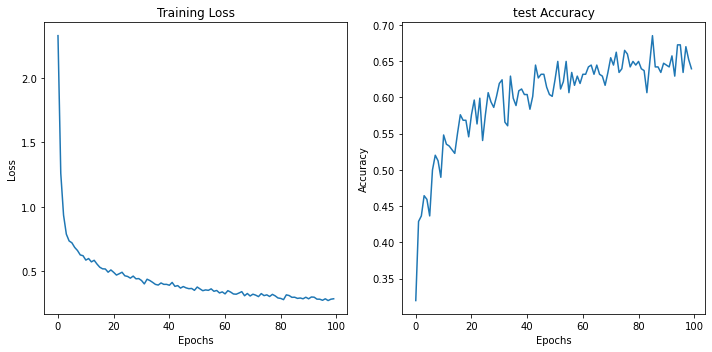

In [28]:
display_model_performance(loss_array_Densenet121, acc_array_Densenet121)

In [29]:
acc_Densenet121 = test(model_Densenet121, test_loader)

            
print("Test Accuracy: ", acc_Densenet121)

Test Accuracy:  0.6421319796954315


In [30]:
# Evaluate the model and get labels and predictions
true_labels, pred_labels = test_with_predictions(model_Resnet18, test_loader)

# Compute confusion matrix
conf_matrix_Densenet121 = confusion_matrix(true_labels, pred_labels)

# Compute classification report
class_report_Densenet121 = classification_report(true_labels, pred_labels)

In [31]:
print("Confusion Matrix:")
print(conf_matrix_Densenet121)

Confusion Matrix:
[[ 35  37  28   0]
 [  2 109   4   0]
 [  1   1 103   0]
 [  1   9  15  49]]


In [32]:
print("\nClassification Report:")
print(class_report_Densenet121)


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.35      0.50       100
           1       0.70      0.95      0.80       115
           2       0.69      0.98      0.81       105
           3       1.00      0.66      0.80        74

    accuracy                           0.75       394
   macro avg       0.82      0.74      0.73       394
weighted avg       0.80      0.75      0.73       394



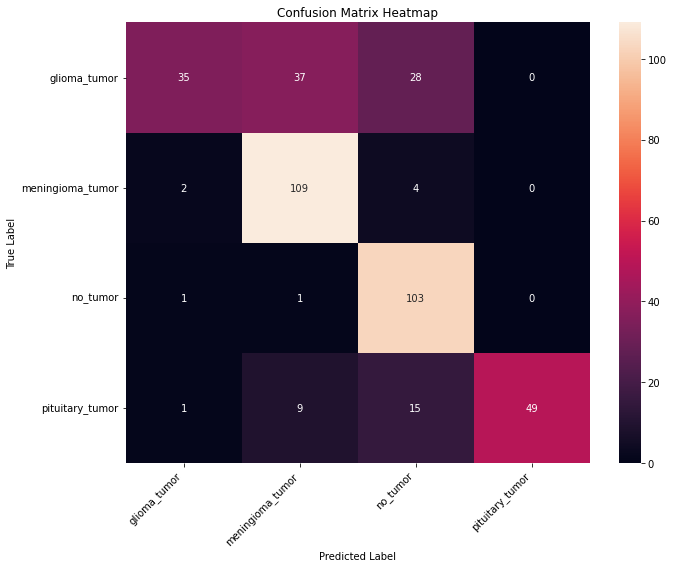

In [33]:
# Plot confusion matrix heatmap
plt.figure(figsize=(10,8))
plt.title("Confusion Matrix Heatmap - Densenet-121")
sns.heatmap(conf_matrix_Densenet121, annot=True, fmt="d", 
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Model Name: GNN-Densenet121


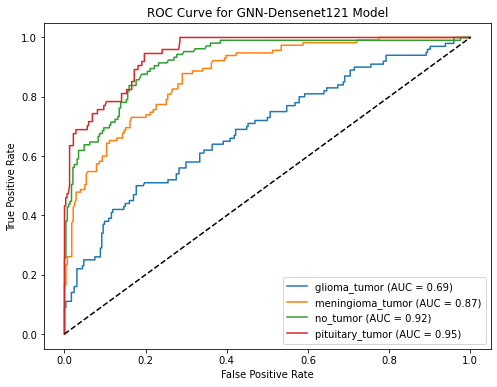

In [34]:
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
plot_roc_curve("GNN-Densenet121", model_Densenet121, test_loader, num_classes=4)

# Instantiating VGG - 16 Model and Visualization

In [35]:
model_VGG16 = GraphCNN_VGG16(k=8,num_classes=4)


loss_array_VGG16, acc_array_VGG16 = train(model_VGG16, 100, train_loader, test_loader, lr=0.001)

            
display_loss_accuracy(loss_array_VGG16, acc_array_VGG16)



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 100/100 [48:09<00:00, 28.90s/it]

Epoch 1 - Loss: 1.1951 - Accuracy: 0.3807
Epoch 2 - Loss: 0.8785 - Accuracy: 0.3985
Epoch 3 - Loss: 0.7083 - Accuracy: 0.3832
Epoch 4 - Loss: 0.6222 - Accuracy: 0.4391
Epoch 5 - Loss: 0.5677 - Accuracy: 0.4365
Epoch 6 - Loss: 0.5372 - Accuracy: 0.5076
Epoch 7 - Loss: 0.5382 - Accuracy: 0.4772
Epoch 8 - Loss: 0.4986 - Accuracy: 0.4949
Epoch 9 - Loss: 0.4875 - Accuracy: 0.5102
Epoch 10 - Loss: 0.4667 - Accuracy: 0.5330
Epoch 11 - Loss: 0.4611 - Accuracy: 0.5203
Epoch 12 - Loss: 0.4528 - Accuracy: 0.5381
Epoch 13 - Loss: 0.4191 - Accuracy: 0.5533
Epoch 14 - Loss: 0.4052 - Accuracy: 0.5609
Epoch 15 - Loss: 0.4104 - Accuracy: 0.5431
Epoch 16 - Loss: 0.4062 - Accuracy: 0.5508
Epoch 17 - Loss: 0.4160 - Accuracy: 0.5685
Epoch 18 - Loss: 0.3809 - Accuracy: 0.5863
Epoch 19 - Loss: 0.3951 - Accuracy: 0.5558
Epoch 20 - Loss: 0.3795 - Accuracy: 0.5838
Epoch 21 - Loss: 0.3649 - Accuracy: 0.5787
Epoch 22 - Loss: 0.3747 - Accuracy: 0.5685
Epoch 23 - Loss: 0.3523 - Accuracy: 0.5914
Epoch 24 - Loss: 0.3

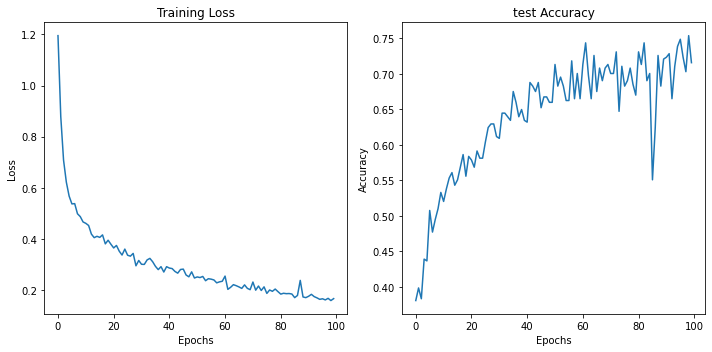

In [36]:
display_model_performance(loss_array_VGG16, acc_array_VGG16)

In [37]:
acc_VGG16 = test(model_VGG16, test_loader)

            
print("Test Accuracy: ", acc_VGG16)

Test Accuracy:  0.7131979695431472


In [38]:
# Evaluate the model and get labels and predictions
true_labels, pred_labels = test_with_predictions(model_Resnet18, test_loader)

# Compute confusion matrix
conf_matrix_VGG16 = confusion_matrix(true_labels, pred_labels)

# Compute classification report
class_report_VGG16 = classification_report(true_labels, pred_labels)

In [39]:
print("Confusion Matrix:")
print(conf_matrix_VGG16)

Confusion Matrix:
[[ 34  36  30   0]
 [  3 107   5   0]
 [  1   1 103   0]
 [  1   9  16  48]]


In [40]:
print("\nClassification Report:")
print(class_report_VGG16)


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.34      0.49       100
           1       0.70      0.93      0.80       115
           2       0.67      0.98      0.80       105
           3       1.00      0.65      0.79        74

    accuracy                           0.74       394
   macro avg       0.81      0.73      0.72       394
weighted avg       0.79      0.74      0.72       394



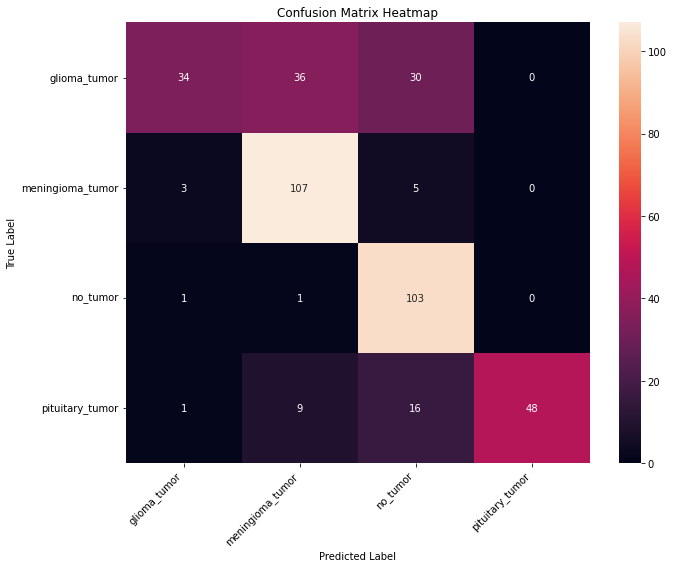

In [41]:
# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
plt.title("Confusion Matrix Heatmap - VGG16")
sns.heatmap(conf_matrix_VGG16, annot=True, fmt="d", 
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Model Name: GNN-VGG16


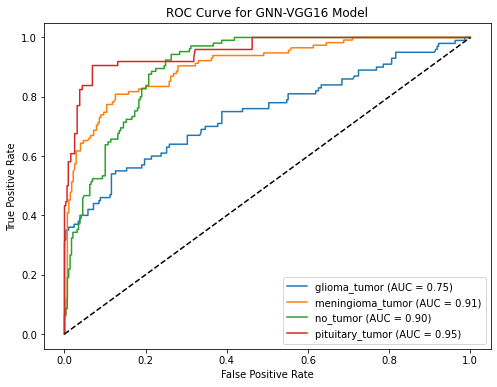

In [42]:
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
plot_roc_curve("GNN-VGG16", model_VGG16, test_loader, num_classes=4)


### Accuracies Table

In [43]:
# Test accuracies obtained for each model
accuracies = [
    ("GraphCNN_VGG16", acc_VGG16),
    ("GraphCNN_Densenet121", acc_Densenet121),
    ("GraphCNN_Resnet18", acc_Resnet18),
]

# Print the accuracies in a visually appealing table (fancy_grid format)
table_str = tabulate(accuracies, headers=["Model", "Test Accuracy"], tablefmt="fancy_grid")

# Display the table
print(table_str)


╒══════════════════════╤═════════════════╕
│ Model                │   Test Accuracy │
╞══════════════════════╪═════════════════╡
│ GraphCNN_VGG16       │        0.713198 │
├──────────────────────┼─────────────────┤
│ GraphCNN_Densenet121 │        0.642132 │
├──────────────────────┼─────────────────┤
│ GraphCNN_Resnet18    │        0.743655 │
╘══════════════════════╧═════════════════╛


# Feature Visualization

In [45]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.type(torch.cuda.HalfTensor)  # Convert to half precision
    return image

In [46]:
def extract_features(model, image_path):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        features = model.forward_features(image_tensor)
    return features

In [47]:
image_path = "/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor/image(100).jpg"

In [48]:
# Extract features using VGG16 model
vgg16_features = extract_features(model_VGG16, image_path)
VGG16_Features_Shape = vgg16_features.shape
print("VGG16 Features :", vgg16_features)

VGG16 Features : tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  2.9668,  4.0039,  0.5186],
          [ 0.0000,  0.1609,  0.0000,  ...,  3.2031,  6.1016,  3.5996],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.5215,  0.2288,  2.2188],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  3.1777],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  2.4551,  0.0000,  0.0000],
          ...,
          [ 0.1567,  0.5308,  5.3477,  ...,  4.8242,  4.5000,  0.0000],
          [ 0.0000,  0.0000,  4.2422,  ...,  5.4805,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.4421,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0

In [49]:
# Extract features using DenseNet121 model
densenet121_features = extract_features(model_Densenet121, image_path)
DenseNet121_Features_Shape = densenet121_features.shape
print("DenseNet121 Features :", densenet121_features)



DenseNet121 Features : tensor([[[[ 3.2163e-04,  1.4343e-03,  2.0695e-04,  ...,  1.4818e-04,
            5.3263e-04, -4.6432e-05],
          [ 7.8630e-04, -1.4222e-04,  4.1127e-06,  ..., -1.6439e-04,
            1.6212e-04,  6.9904e-04],
          [ 2.7347e-04, -6.9380e-04, -8.7452e-04,  ..., -2.8324e-04,
           -4.6349e-04,  4.5919e-04],
          ...,
          [-6.3801e-04, -1.1265e-05,  9.7036e-05,  ..., -2.8706e-04,
            2.8193e-05,  1.1623e-04],
          [ 1.8775e-04, -7.3195e-04, -2.6298e-04,  ..., -7.0477e-04,
           -2.1434e-04,  5.5361e-04],
          [ 3.9411e-04, -3.0339e-05, -8.6260e-04,  ..., -1.2989e-03,
           -4.4847e-04,  2.0838e-04]],

         [[-4.8137e-04,  8.9188e-03,  6.7558e-03,  ...,  2.6112e-03,
            1.3275e-03, -2.6760e-03],
          [ 1.1063e-03,  3.7727e-03, -4.5547e-03,  ...,  8.7204e-03,
            2.9774e-03, -4.5815e-03],
          [-3.1033e-03, -2.1095e-03, -1.6006e-02,  ...,  1.5656e-02,
            4.2305e-03,  4.0474e-03

In [50]:
# Extract features using ResNet18 model
resnet18_features = extract_features(model_Resnet18, image_path)
ResNet18_Features_Shape = resnet18_features.shape
print("ResNet18 Features :", resnet18_features)

ResNet18 Features : tensor([[[[0.0042, 1.0439, 1.6543,  ..., 0.9331, 0.0000, 0.0000],
          [0.3081, 0.8848, 1.3037,  ..., 1.6377, 0.4246, 0.3013],
          [0.0184, 0.4456, 2.2754,  ..., 2.7227, 1.1094, 0.4314],
          ...,
          [0.2766, 0.9458, 2.2832,  ..., 1.9922, 0.7979, 0.5698],
          [0.0000, 0.0000, 0.1597,  ..., 0.5107, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2233, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.5225, 0.3130, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5356, 0.3813],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0214],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0872, 0.0000, 0.0000],
          [0.1044, 0.3574, 0.9263,  ..., 0.9829, 0.0000, 0.0000],
          [0.4678, 0.0

In [51]:

# Test accuracies obtained for each model
Features = [
    ("ResNet18 Features", ResNet18_Features_Shape),
    ("DenseNet121 Features", DenseNet121_Features_Shape),
    ("VGG16 Features", VGG16_Features_Shape),
]

# Print the accuracies in a visually appealing table (fancy_grid format)
table_Features = tabulate(Features, headers=["Model", "Test Accuracy"], tablefmt="fancy_grid")

# Display the table
print(table_Features)

╒══════════════════════╤═════════════════════════════╕
│ Model                │ Test Accuracy               │
╞══════════════════════╪═════════════════════════════╡
│ ResNet18 Features    │ torch.Size([1, 512, 7, 7])  │
├──────────────────────┼─────────────────────────────┤
│ DenseNet121 Features │ torch.Size([1, 1024, 7, 7]) │
├──────────────────────┼─────────────────────────────┤
│ VGG16 Features       │ torch.Size([1, 512, 7, 7])  │
╘══════════════════════╧═════════════════════════════╛


In [52]:
def preprocess_image_visualize(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(torch.float16).cuda()  # Convert to half precision and move to GPU
    return image

def extract_features_visualize(model, image_path):
    model.eval()
    with torch.no_grad():
        image_tensor = preprocess_image_visualize(image_path)
        features = model.forward_features(image_tensor)
    return features

In [53]:
def reduce_features(features, n_components=2):
    # Flatten the features to (n_samples, n_features)
    flattened_features = features.squeeze().cpu().numpy()
    flattened_features = flattened_features.reshape(flattened_features.shape[0], -1)
    
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(flattened_features)
    return reduced_features

In [54]:

# Extract features using VGG16 model
vgg16_features_visualize = extract_features_visualize(model_VGG16, image_path)
reduced_vgg16_features = reduce_features(vgg16_features_visualize)


In [55]:
# Extract features using DenseNet121 model
densenet121_features_visualize = extract_features_visualize(model_Densenet121, image_path)
reduced_densenet121_features = reduce_features(densenet121_features_visualize)

In [56]:
# Extract features using ResNet18 model
resnet18_features_visualize = extract_features_visualize(model_Resnet18, image_path)
reduced_resnet18_features = reduce_features(resnet18_features_visualize)

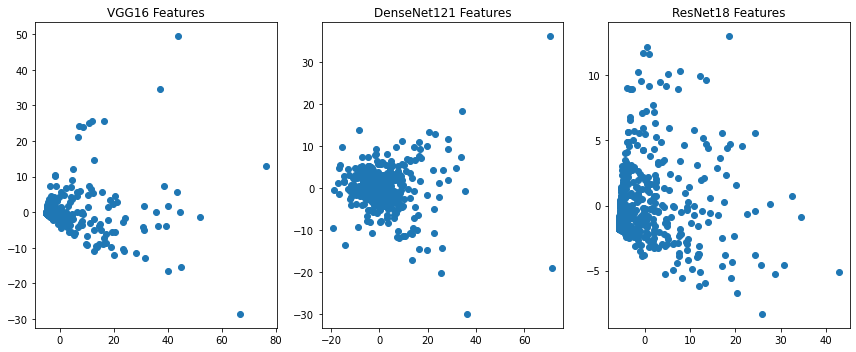

In [57]:
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.scatter(reduced_vgg16_features[:, 0], reduced_vgg16_features[:, 1])
plt.title('VGG16 Features')

plt.subplot(1, 3, 2)
plt.scatter(reduced_densenet121_features[:, 0], reduced_densenet121_features[:, 1])
plt.title('DenseNet121 Features')

plt.subplot(1, 3, 3)
plt.scatter(reduced_resnet18_features[:, 0], reduced_resnet18_features[:, 1])
plt.title('ResNet18 Features')

plt.tight_layout()
plt.show()